# An Introduction to the Amazon Fraud Detector API  


## Introduction
-------

Amazon Fraud Detector is a fully managed service that makes it easy to identify potentially fraudulent online activities, such as online payment fraud and the creation of fake accounts. 

In this notebook, we'll use the Amazon Fraud Detector API to define an entity and event of interest and use CSV data stored in S3 to train a model. Next, we'll derive some rules and create a "detector" by combining our entity, event, model, and rules into a single endpoint. Finally, we'll apply the detector to a sample of our data to identify potentially fraudulent events.

After running this notebook you should be able to:
- Define an Entity and Event
- Create a Detector
- Train a Machine Learning (ML) Model
- Author Rules to identify potential fraud based on the model's score
- Apply the Detector's "predict" function, to generate a model score and rule outcomes on data

If you would like to know more, please check out [Fraud Detector's Documentation](https://docs.aws.amazon.com/frauddetector/). 


## Setup
------
First setup your AWS credentials so that Fraud Detector can store and access training data and supporting detector artifacts in S3.

Detailed information on setting-up: https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

To use Amazon Fraud Detector, you have to set up **permissions** that allow access to the Amazon Fraud Detector console and API operations. You also have to **allow Amazon Fraud Detector to perform tasks on your behalf** and to **access resources that you own**. We recommend creating an AWS Identity and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.

The following policies provide the required permission to use Amazon Fraud Detector:

- **AmazonFraudDetectorFullAccessPolicy**  
    Allows you to perform the following actions:  
    - Access all Amazon Fraud Detector resources  
    - List and describe all model endpoints in Amazon SageMaker  
    - List all IAM roles in the account  
    - List all Amazon S3 buckets  
    - Allow IAM Pass Role to pass a role to Amazon Fraud Detector  

- **AmazonS3FullAccess**  
    Allows full access to Amazon S3. This is required to upload training files to S3.  

**IMPORTANT**: each SageMaker notebook needs to assume an **AWS IAM role**. The role of this notebook should include the above 2 policies, and also include in the **Trusted Relationships** the fraud detector service **frauddetector.amazonaws.com**. The final Trusted Relationships part of the role should look similar to this: 

```
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": [
          "sagemaker.amazonaws.com",
          "frauddetector.amazonaws.com"
        ]
      },
      "Action": "sts:AssumeRole"
    }
  ]
}
```


## Plan
------
A *Detector* contains the event, model(s) and rule(s) detection logic for a particular type of fraud that you want to detect. We'll use the following 7 step process to plan a Fraud Detector: 

1. [Setup your notebook](#Step-1:-Setup-and-verify-your-Python-environment)
    - name the major components entity, entity type, model, detector .
    - plug in your ARN role
    - plug in your S3 Bucket and CSV File


2. [Read and understand your data](#Step-2:-Read-and-understand-your-data)
    - this will give you an idea of what your dataset contains. 
    - this will also identify the variables and labels that will need to be created to define your event. 
 

3. [Create event Variables and Labels](#Step-3:-Create-Variables-and-Labels)
    - this will create the variables and labels in fraud detector 
  

4. [Define your Entity and Event Type](#Step-4:-Define-Entity-and-Event-type)
    - What is activity that you are detecting? that's likely your Event Type ex. account_registration
    - Who is performing this activity? that's likely your Entity ex. customer 


5. [Create and train your Model](#Step-5:-Create-and-train-a-ML-model)
    - model training takes anywhere from 45-60 minutes, once complete you need to promote your endpoint  
    - promote your model


6. [Create Detector, generate Rules and assemble your Detector](#Step-6:-Create-a-Detector,-Outcome,-Rules,-and-Detector-version)
    - create your detector 
    - create rules based on your model scores: define outcomes ex:  fraud, investigate and approve 
    - assemble your detector: combines rules and model into a "detector


7. [Test your Detector](#Step-7:-Get-fraud-predictions)
    - Interactively call predict on a handful of record 
     
------

# Step 1: Setup and verify your Python environment
Boto3 is the Amazon Web Services (AWS) SDK for Python. It enables Python developers to create, configure, and manage AWS services. You can find more details about Boto3 Fraud Detector [here](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html). 

In [1]:
import boto3  # Python library for interacting with AWS resources

fraudDetector_client = boto3.client('frauddetector')  # create a fraud detector client

response = fraudDetector_client.get_detectors()
print(response)

{'detectors': [], 'ResponseMetadata': {'RequestId': '362d8189-a3f0-48b9-8b36-b14d001c0e16', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Thu, 10 Sep 2020 03:21:50 GMT', 'x-amzn-requestid': '362d8189-a3f0-48b9-8b36-b14d001c0e16', 'content-length': '16', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


We now have to define the role and data location that we will be using.

In [3]:
ARN_ROLE       = "arn:aws:iam::482414474587:role/service-role/AmazonSageMaker-ExecutionRole-20200907T214769" 
S3_BUCKET      = "fraud-detector-example-useast2"
S3_FILE        = "registration_data_20K_full.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)


# Step 2: Read and understand your data

We will be using the sample dataset provided in the Amazon Fraud Detector documentation. The dataset must be in a CSV format and uploaded to an S3 bucket in the same region with the Fraud Detector. For more information on the dataset and how to upload it to S3, please check [here](https://docs.aws.amazon.com/frauddetector/latest/ug/step-1-get-s3-data.html).

In [4]:
import pandas as pd

# connect to S3, get csv file, and convert it to a pandas dataframe
s3_client = boto3.resource('s3')
s3_object = s3_client.Object(S3_BUCKET, S3_FILE)
body = s3_object.get()['Body']
df_data = pd.read_csv(body)

In [5]:
df_data.head(5)

,ip_address,email_address,billing_state,user_agent,billing_postal,phone_number,EVENT_TIMESTAMP,billing_address,EVENT_LABEL
0,112.136.132.151,fake_cgonzales@example.net,NC,Mozilla/5.0 (iPad; CPU iPad OS 10_3_3 like Mac...,34491,(555)333 - 9246,2020-02-22 01:38:31,12351 Amanda Knolls Fake St.,legit
1,192.169.234.143,fake_dustin64@example.net,CO,Mozilla/5.0 (Windows; U; Windows NT 6.1) Apple...,34555,(555)779 - 5604,2020-04-08 23:29:41,691 Deborah Estate Fake St.,legit
2,185.112.224.79,fake_samuel59@example.net,CO,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_7...,33611,(555)948 - 9198,2020-06-28 10:26:20,28583 Joseph Tunnel Fake St.,legit
3,68.73.183.186,fake_tinalopez@example.net,TN,Mozilla/5.0 (Linux; Android 7.1.1) AppleWebKit...,33520,(555)477 - 7885,2020-04-28 10:23:36,019 Linda Via Fake St.,legit
4,117.65.246.206,fake_alyssa53@example.com,NM,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,33889,(555)873 - 2599,2020-06-07 16:42:35,1023 Cook Loaf Fake St.,legit


In [6]:
df_data.info()  # general info about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ip_address       20000 non-null  object
 1   email_address    20000 non-null  object
 2   billing_state    20000 non-null  object
 3   user_agent       20000 non-null  object
 4   billing_postal   20000 non-null  int64 
 5   phone_number     20000 non-null  object
 6   EVENT_TIMESTAMP  20000 non-null  object
 7   billing_address  20000 non-null  object
 8   EVENT_LABEL      20000 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.4+ MB


Our dataframe has **20K records**, and **9 features**. Of these 9 features, 2 are mandatory for Amazon Fraud Detector: ```EVENT_TIMESTAMP``` and ```EVENT_LABEL```. The rest 7 features can be used as **variables** in Amazon Fraud Detector, in order to train a Machine Learning model. 

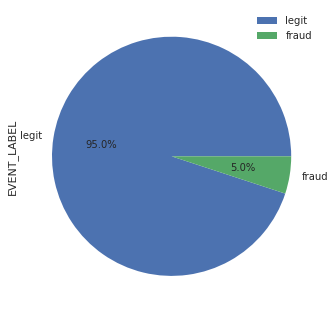

In [7]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
df_data.EVENT_LABEL.value_counts().plot.pie(legend=True, autopct='%1.1f%%')
plt.show()

As expected, there is a big class imbalance. However, Amazon Fraud Detector can take care of these cases, as long as, **fraudulent cases are more than 4%** of the whole data, or 400 cases within a 10K dataset.

# Step 3: Create Variables and Labels

## Variables
Variables are the *features* that we will use in our ML models. We have to choose which of the dataframe columns will be used for that, and we have to **map** them to the specific **variable types** that Amazon Fraud Detector offers. More information about the list of available variable types can be found [here](https://docs.aws.amazon.com/frauddetector/latest/ug/create-a-variable.html#variable-types).

In [8]:
# Create variable email_address
fraudDetector_client.create_variable(
    name = 'email_address',
    variableType = 'EMAIL_ADDRESS',
    dataSource = 'EVENT',
    dataType = 'STRING',
    defaultValue = '<unknown>'
)

# Create variable ip_address
fraudDetector_client.create_variable(
    name = 'ip_address',
    variableType = 'IP_ADDRESS',
    dataSource = 'EVENT',
    dataType = 'STRING',
    defaultValue = '<unknown>'
)

# Create variable billing_state
fraudDetector_client.create_variable(
    name = 'billing_state',
    variableType = 'BILLING_STATE',
    dataSource = 'EVENT',
    dataType = 'STRING',
    defaultValue = '<unknown>'
)

# Create variable user_agent
fraudDetector_client.create_variable(
    name = 'user_agent',
    variableType = 'USERAGENT',
    dataSource = 'EVENT',
    dataType = 'STRING',
    defaultValue = '<unknown>'
)

# Create variable billing_postal
fraudDetector_client.create_variable(
    name = 'billing_postal',
    variableType = 'BILLING_ZIP',
    dataSource = 'EVENT',
    dataType = 'STRING',
    defaultValue = '<unknown>'
)

# Create variable phone_number
fraudDetector_client.create_variable(
    name = 'phone_number',
    variableType = 'PHONE_NUMBER',
    dataSource = 'EVENT',
    dataType = 'STRING',
    defaultValue = '<unknown>'
)

# Create variable billing_address
fraudDetector_client.create_variable(
    name = 'billing_address',
    variableType = 'BILLING_ADDRESS_L1',
    dataSource = 'EVENT',
    dataType = 'STRING',
    defaultValue = '<unknown>'
)

{'ResponseMetadata': {'RequestId': '35e10222-c381-423e-989f-586ac8f82b96',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 03:22:46 GMT',
   'x-amzn-requestid': '35e10222-c381-423e-989f-586ac8f82b96',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Labels
Labels are the **ground truth values that describe whether an event is fraudulent or legitimate**. This has to be **exactly** the same word that is used in our CSV file. For example, a fraudulent case could be highlighted as 'fraud', 'Fraud', '1', 'F' etc., while a legitimate even could be indicated as 'legit', 'Legit', '0', 'L' etc. We have to use exactly the same notation with our CSV file, when creating our labels.

In [9]:
# create label for fraud
fraudDetector_client.put_label(
    name = 'fraud',
    description = 'label for fraud events'
)

# create label for legit
fraudDetector_client.put_label(
    name = 'legit',
    description = 'label for legitimate events'
)

{'ResponseMetadata': {'RequestId': 'bf1a4836-70f9-4f9f-8158-4ea866e34484',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 03:23:21 GMT',
   'x-amzn-requestid': 'bf1a4836-70f9-4f9f-8158-4ea866e34484',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Step 4: Define Entity and Event type

## Entity type
Entity type describes **who** will perform an actibity (event), for which, we would like to analyze for fraudulent activity. In many cases this is a customer.

In [10]:
# create an entity type
fraudDetector_client.put_entity_type(
    name = 'sample_customer',
    description = 'sample customer entity type'
)

{'ResponseMetadata': {'RequestId': '7f745a2c-d57a-4f76-bd08-85f9a621470b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 03:23:23 GMT',
   'x-amzn-requestid': '7f745a2c-d57a-4f76-bd08-85f9a621470b',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Event type
Event is the **activity** that the Entity will perform, which will be analyzed by Amazon Fraud Detector. Once defined, you can build Models and Detectors that evaluate the risk for specific event types. For example, an Event could be a "sample registration" task that a customer would perform. Other Event types could be an online transaction, the submission of a comment/review etc. When we define an Event type, we need to also include the Variables and Labels that we created in our previous step.

In [11]:
fraudDetector_client.put_event_type(
    name = 'sample_registration',
    eventVariables = ['ip_address', 'email_address', 'billing_state', 'user_agent', 'billing_postal', 'phone_number', 'billing_address'],
    labels = ['legit', 'fraud'],
    entityTypes = ['sample_customer']
)

{'ResponseMetadata': {'RequestId': '1b866168-7386-49f8-8888-02a1bd53c00e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 03:23:28 GMT',
   'x-amzn-requestid': '1b866168-7386-49f8-8888-02a1bd53c00e',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Step 5: Create and train a ML model

Amazon Fraud Detector models learn to detect fraud for a specific event type. In Amazon Fraud Detector, you **first create a Model**, which acts as a **container** for your **Model versions**. Each time you train a model, a new version is created. 

A model version is created by calling the ```CreateModel``` and ```CreateModelVersion``` operations. 

- ```CreateModel``` initiates the model, which acts as a container for your model versions. 

- ```CreateModelVersion``` starts the training process, which results in a specific version of the model. A new version of the solution is created each time you call ```CreateModelVersion```. 


In [12]:
MODEL_NAME = 'sample_fraud_detection_model_all_variables'
               

In [13]:
# create model container
fraudDetector_client.create_model(
    modelId = MODEL_NAME,
    eventTypeName = 'sample_registration',
    modelType = 'ONLINE_FRAUD_INSIGHTS'
)

{'ResponseMetadata': {'RequestId': '3384fc0c-9355-433f-981c-6cf2bc9ecd49',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 03:23:35 GMT',
   'x-amzn-requestid': '3384fc0c-9355-433f-981c-6cf2bc9ecd49',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [ ]:
# start training a new model version
fraudDetector_client.create_model_version (
    modelId = MODEL_NAME,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = {
        'modelVariables' : ['ip_address', 'email_address', 'billing_state', 'user_agent', 'billing_postal', 'phone_number', 'billing_address'],
        'labelSchema' : {
            'labelMapper' : {
                'FRAUD' : ['fraud'],
                'LEGIT' : ['legit']
            }
        }
    }, 
    externalEventsDetail = {
        'dataLocation' : S3_FILE_LOC,
        'dataAccessRoleArn' : ARN_ROLE
    }
)

Training can take saveral hours, depending on your dataset. In order to know how training progresses, we add a small piece of code that **polls the training process** in regular intervals and displays the progress. 

In [18]:
import time

training_state = None
while training_state != "TRAINING_COMPLETE":
    response = fraudDetector_client.get_model_version(
        modelId = MODEL_NAME, 
        modelType = "ONLINE_FRAUD_INSIGHTS", 
        modelVersionNumber = '1.0'
    )
    training_state = response['status']
    print("-", end="")
    time.sleep(60)  # poll once every 1 min

print("\nTraining state:", training_state)

-
Training state: TRAINING_COMPLETE


Amazon Fraud Detector keeps aside 10% of the data for validation/testing purposes. You can check the performance of the model by requesting the ROC AUC metric.

In [19]:
# get model report for the trained model

model_report = fraudDetector_client.describe_model_versions(
    modelId = MODEL_NAME,
    modelVersionNumber = '1.0',
    modelType = 'ONLINE_FRAUD_INSIGHTS'
)

print('ROC AUC: ',model_report['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc'])

ROC AUC:  0.9558449387550354


After reviewing the model performance, we need to **activate the Model** to make it available for use by Detectors, in real-time fraud predictions. Amazon Fraud Detector will deploy the model in **multiple availability zones** for redundancy with **auto-scaling turned on** to ensure the model scales with the number of fraud predictions you are making. To activate the model, call the ```UpdateModelVersionStatus``` API and update the status to ```ACTIVE```.

In [20]:
# select model status
MODEL_STATUS = 'ACTIVE' 
# MODEL_STATUS = 'INACTIVE'

response = fraudDetector_client.update_model_version_status (
modelId = MODEL_NAME,
modelType = 'ONLINE_FRAUD_INSIGHTS',
modelVersionNumber = '1.00',
status = MODEL_STATUS
)


Deployment may take ~10min, so, we also poll regularly, to know how the process progresses.

In [21]:
deployment_state = None
while deployment_state != MODEL_STATUS:
    response = fraudDetector_client.get_model_version(
        modelId = MODEL_NAME, 
        modelType = "ONLINE_FRAUD_INSIGHTS", 
        modelVersionNumber = '1.0'
    )
    deployment_state = response['status']
    print("-", end="")
    time.sleep(60)  # poll once every 1 min

print("\nDeployment state:", deployment_state)


-----------
Deployment state: ACTIVE


# Step 6: Create a Detector, Outcome, Rules, and Detector version

A detector contains the detection logic, such as the models and rules, for a particular event that you want to evaluate for fraud. During a fraud prediction, you will specify the detector that you want to use to evaluate your event. To create a detector, complete the following steps. 

i. **Create a detector**. A detector acts as a container for your detector versions.

In [22]:
DETECTOR_NAME = 'sample_detector_all_variables'
               

In [23]:
fraudDetector_client.put_detector (
    detectorId = DETECTOR_NAME,
    eventTypeName = 'sample_registration'
)

{'ResponseMetadata': {'RequestId': '575eb085-62d4-4d4c-95de-d151e6e82e11',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 04:38:56 GMT',
   'x-amzn-requestid': '575eb085-62d4-4d4c-95de-d151e6e82e11',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

ii. **Create outcomes**. An outcome is the result of a fraud prediction. Create an outcome for each possible fraud prediction result. For example, you may want outcomes to represent risk levels (high_risk, medium_risk, and low_risk) or actions (approve, review). Once created, you can add one or more outcomes to a rule.

In [24]:
# for high risk cases
fraudDetector_client.put_outcome(
    name = 'verify_customer',
    description = 'this outcome initiates a verification workflow'
)

# for medium risk cases
fraudDetector_client.put_outcome(
    name = 'review',
    description = 'this outcome sidelines event for review'
)

# for low risk cases
fraudDetector_client.put_outcome(
    name = 'approve',
    description = 'this outcome approves the event'
)

{'ResponseMetadata': {'RequestId': '9c3549d6-5092-4bdf-8a95-272a3c321d23',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 04:39:00 GMT',
   'x-amzn-requestid': '9c3549d6-5092-4bdf-8a95-272a3c321d23',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

iii. **Create rules**. A rule is a condition that tells Amazon Fraud Detector how to interpret variable values during a fraud prediction. A rule consists of one or more variables, a logic expression, and one or more outcomes. A **detector must have at least one associated rule**. Rules in a detector are evaluated as part of a fraud prediction. 
 
 Each rule must contain a single expression that captures your business logic. All expressions must evaluate to a Boolean value (true or false) and be less than 4,000 characters in length. If-else type conditions are not supported. All variables used in the expression must be predefined in the evaluated event type. 

In [31]:
# in order to use the model score with rules, we need to construct a predefined variable name

MODEL_INSIGHTS = MODEL_NAME + '_insightscore'  # to be used when getting real-time predictions
MODEL_SCORE = '$' + MODEL_INSIGHTS  # to be used when defining rules


In [26]:
# for high risk cases
fraudDetector_client.create_rule(
    ruleId = 'high_fraud_risk',
    detectorId = DETECTOR_NAME,
    expression = MODEL_SCORE + ' > 900',
    language = 'DETECTORPL',
    outcomes = ['verify_customer']
)

# for medium risk cases
fraudDetector_client.create_rule(
    ruleId = 'medium_fraud_risk',
    detectorId = DETECTOR_NAME,
    expression = MODEL_SCORE + ' <= 900 and ' + MODEL_SCORE + ' > 700',
    language = 'DETECTORPL',
    outcomes = ['review']
)

# for low risk cases
fraudDetector_client.create_rule(
    ruleId = 'low_fraud_risk',
    detectorId = DETECTOR_NAME,
    expression = MODEL_SCORE + ' <= 700',
    language = 'DETECTORPL',
    outcomes = ['approve']
)

{'rule': {'detectorId': 'sample_detector_all_variables',
  'ruleId': 'low_fraud_risk',
  'ruleVersion': '1'},
 'ResponseMetadata': {'RequestId': '4930d306-670d-4568-ba67-7aefdb04ea1d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 04:39:06 GMT',
   'x-amzn-requestid': '4930d306-670d-4568-ba67-7aefdb04ea1d',
   'content-length': '99',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

You can **update a rule** by calling the ```UpdateRuleVersion``` API. The following example updates the model score thresholds for the rules high_fraud_risk and medium_fraud_risk from 900 to 950. 

In [28]:
fraudDetector_client.update_rule_version(
    rule = {
        'detectorId' : DETECTOR_NAME,
        'ruleId' : 'high_fraud_risk',
        'ruleVersion' : '1'
    },
    expression = MODEL_SCORE + ' > 950',
    language = 'DETECTORPL',
    outcomes = ['verify_customer']
)

fraudDetector_client.update_rule_version(
    rule = {
        'detectorId' : DETECTOR_NAME,
        'ruleId' : 'medium_fraud_risk',
        'ruleVersion' : '1'
    },
    expression = MODEL_SCORE + ' <= 950 and ' + MODEL_SCORE + ' > 700',
    language = 'DETECTORPL',
    outcomes = ['review']
)

{'rule': {'detectorId': 'sample_detector_all_variables',
  'ruleId': 'medium_fraud_risk',
  'ruleVersion': '2'},
 'ResponseMetadata': {'RequestId': '5a866a0b-24c7-447b-b5a8-23c1e55c1b85',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 04:39:58 GMT',
   'x-amzn-requestid': '5a866a0b-24c7-447b-b5a8-23c1e55c1b85',
   'content-length': '102',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

iv. **Create a detector version**. A detector version defines the specific models and rules that will be run as part of a fraud prediction. Each detector version has a status of ```DRAFT```, ```ACTIVE```, or ```INACTIVE```. Only one detector version can be in ```ACTIVE``` status at a time. During the ```GetEventPrediction``` request, Amazon Fraud Detector will use the ```ACTIVE``` detector if no ```DetectorVersion``` is specified. 

In [29]:
fraudDetector_client.create_detector_version(
    detectorId = DETECTOR_NAME,
    rules = [{
        'detectorId' : DETECTOR_NAME,
        'ruleId' : 'high_fraud_risk',
        'ruleVersion' : '1'
    },
    {
        'detectorId' : DETECTOR_NAME,
        'ruleId' : 'medium_fraud_risk',
        'ruleVersion' : '1'
    },
    {
        'detectorId' : DETECTOR_NAME,
        'ruleId' : 'low_fraud_risk',
        'ruleVersion' : '1'
    }
    ],
    modelVersions = [{
        'modelId' : MODEL_NAME,
        'modelType': 'ONLINE_FRAUD_INSIGHTS',
        'modelVersionNumber' : '1.00'
    }],
    ruleExecutionMode = 'FIRST_MATCHED'
)

# activate the newly created detector
fraudDetector_client.update_detector_version_status(
    detectorId = DETECTOR_NAME,
    detectorVersionId = '1',
    status = 'ACTIVE'
)

{'ResponseMetadata': {'RequestId': '0dfe98c4-3486-4f33-b48e-b932a9f94b25',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 10 Sep 2020 04:40:12 GMT',
   'x-amzn-requestid': '0dfe98c4-3486-4f33-b48e-b932a9f94b25',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Step 7: Get fraud predictions

Getting one individual prediction (legit case).

In [32]:
response = fraudDetector_client.get_event_prediction(
    detectorId = DETECTOR_NAME,
    eventId = '802454d3-f7d8-482d-97e8-c4b6db9a0428',
    eventTypeName = 'sample_registration',
    eventTimestamp = '2020-07-13T23:18:21Z',
    entities = [{'entityType':'sample_customer', 'entityId':'12345'}],
    eventVariables = {
        'email_address' : 'johndoe@exampledomain.com',
        'ip_address' : '1.2.3.4',
        'billing_state': 'TX',
        'user_agent': 'Mozilla/5.0 (iPad; CPU iPad OS 10_3_3 like Mac OS X) AppleWebKit/532.2 (KHTML, like Gecko) CriOS/34.0.827.0 Mobile/13K063 Safari/532.2',
        'billing_postal': '34491',
        'phone_number': '(555)333 - 9246',
        'billing_address': '12351 Amanda Knolls Fake St.'  
    }
)

print('ML fraud prediction [0,1000]:', response['modelScores'][0]['scores'][MODEL_INSIGHTS])
print('Activated rule:', response['ruleResults'][0]['ruleId'])
print('Outcome:', response['ruleResults'][0]['outcomes'][0])

ML fraud prediction [0,1000]: 363.0
Activated rule: low_fraud_risk
Outcome: approve


Getting one individual prediction (fraudulent case).

In [33]:
response = fraudDetector_client.get_event_prediction(
    detectorId = DETECTOR_NAME,
    eventId = '802454d3-f7d8-482d-97e8-c4b6db9a0428',
    eventTypeName = 'sample_registration',
    eventTimestamp = '2020-07-13T23:18:21Z',
    entities = [{'entityType':'sample_customer', 'entityId':'12345'}],
    eventVariables = {
        'email_address' : 'fake_timothysmith@example.com',
        'ip_address' : '59.157.144.1',
        'billing_state': 'AZ',
        'user_agent': 'Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like Mac OS X; sid-ET) AppleWebKit/534.17.7 (KHTML, like Gecko) Version/4.0.5 Mobile/8B118 Safari/6534.17.7',
        'billing_postal': '32931',
        'phone_number': '(555)596 - 5579',
        'billing_address': '65898 Amy Estate Fake St.'  
    }
)

print('ML fraud prediction [0,1000]:', response['modelScores'][0]['scores'][MODEL_INSIGHTS])
print('Activated rule:', response['ruleResults'][0]['ruleId'])
print('Outcome:', response['ruleResults'][0]['outcomes'][0])

ML fraud prediction [0,1000]: 1000.0
Activated rule: high_fraud_risk
Outcome: verify_customer
